# Getting started with the D+ API
This Jupyter notebook was written to help new users understand how to work with the API.
The reading of the documentation is still extremely recommended to really understand the inner workings.

First, we need import the basic modules which we will (almost) always need:

In [1]:
from dplus.CalculationInput import CalculationInput # To create states
from dplus.CalculationRunner import EmbeddedLocalRunner # To access the backend and run the calculation

runner = EmbeddedLocalRunner()

Now, we shall build our state, containing a sphere of radius 2nm and electron density 400

In [2]:
from dplus.DataModels.models import Sphere

q_max = 10
grid_size = 50

Test_sphere = Sphere()
Test_sphere.layer_params[1].radius.value = 2
Test_sphere.layer_params[1].ed.value = 400

# Create a calculation state
state = CalculationInput()
state.Domain.populations[0].add_model(Test_sphere)

We note that our state is built with a lot of default values, like q_max (7.5) or grid_size.
We will change it now so that we'll calculate up to q = 10, and according to Suggest Parameters, we need a grid size of 50.
To get a good resolution, we will define 1000 calculation points, and make sure we run it on our GPU.

In [3]:
state.DomainPreferences.grid_size = grid_size
state.DomainPreferences.q_max = q_max
state.DomainPreferences.generated_points = 1000
state.use_gpu = True

And now we run!

In [4]:
output = runner.generate(state)
sphere_amp = runner.get_amp(Test_sphere.model_ptr) ## Get the amplitude of the sphere (for later use)

Now we shall plot the result (in semi-log scale)

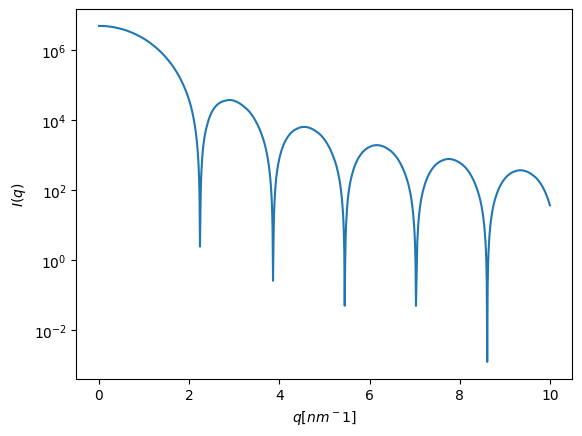

In [5]:
import matplotlib.pyplot as plt

q = list(output.graph.keys())
I_q = list(output.graph.values())

plt.semilogy(q, I_q)
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.show()

Or a Uniform Hollow Cylinder:

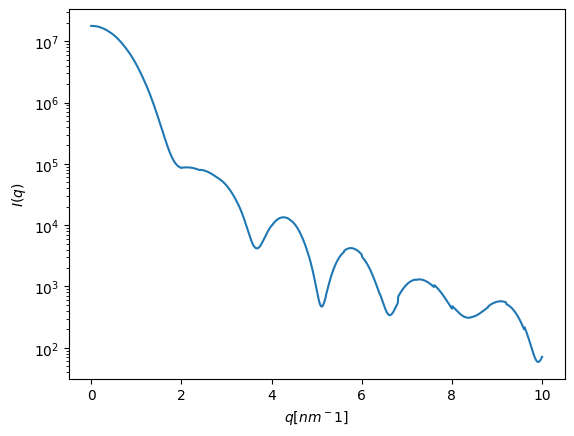

In [6]:
from dplus.DataModels.models import UniformHollowCylinder

Test_uhc = UniformHollowCylinder()
Test_uhc.layer_params[1].radius.value = 2
Test_uhc.layer_params[1].ed.value = 400
Test_uhc.extra_params.height.value = 5

# Create a calculation state
state_uhc = CalculationInput()
state_uhc.Domain.populations[0].add_model(Test_uhc)
state_uhc.DomainPreferences.use_grid = True
state_uhc.DomainPreferences.grid_size = grid_size
state_uhc.DomainPreferences.q_max = q_max
state_uhc.DomainPreferences.generated_points = 1000
state_uhc.use_gpu = True

output_uhc = runner.generate(state_uhc)
uhc_amp = runner.get_amp(Test_uhc.model_ptr) ## Get the amplitude of the UHC (for later use)

q_uhc = list(output_uhc.graph.keys())
I_q_uhc = list(output_uhc.graph.values())

plt.semilogy(q_uhc, I_q_uhc)
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.show()

If we want to give this sphere some polydispersity and recalculate:

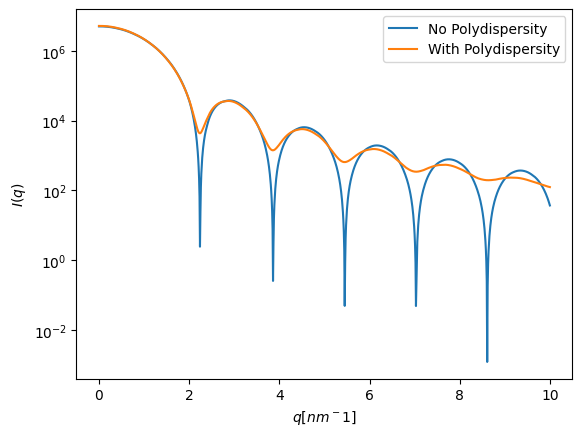

In [7]:
Test_sphere.layer_params[1].radius.sigma = .1

output_w_pd = runner.generate(state)

I_q_w_pd = list(output_w_pd.graph.values())

plt.semilogy(q, I_q, label='No Polydispersity')
plt.semilogy(q, I_q_w_pd, label='With Polydispersity')
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.legend()
plt.show()

We can also calculate the scattering in the case we have a resolution function:

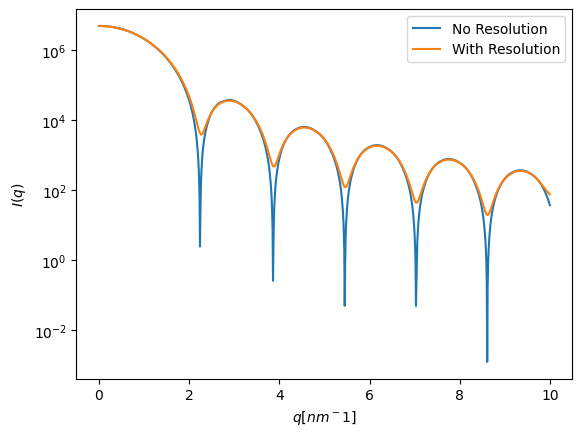

In [8]:
Test_sphere.layer_params[1].radius.sigma = 0 # Reset the polydispersity to 0

state.DomainPreferences.apply_resolution = True
state.DomainPreferences.resolution_sigma = 0.1

output_w_res = runner.generate(state)

I_q_w_res = list(output_w_res.graph.values())

plt.semilogy(q, I_q, label='No Resolution')
plt.semilogy(q, I_q_w_res, label='With Resolution')
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.legend()
plt.show()

Let's now build to more states, one with just a PDB as model and the second one after putting this PDB inside a manual symmetry that we shall build:

In [9]:
from dplus.DataModels.models import PDB
from dplus.DataModels import ManualSymmetry
import dplus.g_r as g
import numpy as np

## Create a PDB
Test_PDB = PDB(r'../CF4.pdb')
Test_PDB.centered = True # Make sure the PDB is centered
Test_PDB.extra_params.solvent_method.value = 0

## Create a calculation state for only the PDB
state_PDB = CalculationInput()
state_PDB.Domain.populations[0].add_model(Test_PDB)
state_PDB.DomainPreferences.grid_size = 100
state_PDB.DomainPreferences.q_max = 15
state_PDB.DomainPreferences.generated_points = 1500
state_PDB.use_gpu = True

In [10]:
## Create a cubic lattice with the PDB
Test_PDB_sym = PDB(r'../CF4.pdb')
Test_PDB_sym.centered = True # Make sure the PDB is centered
Test_PDB_sym.extra_params.solvent_method.value = 0

a = 3.5
cubic_lattice = a * np.identity(3)
repx = 10
repy = 10
repz = 10
Lx = repx * a
Ly = repy * a
Lz = repz * a
filename_out = r'../CF4_10x10x10.dol'
dol_mat = g.build_crystal(cubic_lattice, repx, repy, repz, filename_out)

PDB_sym = ManualSymmetry()
PDB_sym.read_from_dol(filename_out)
PDB_sym.use_grid = False
PDB_sym.children.append(Test_PDB_sym)

## Create a calculation state for the PDB in a cubic lattice
state_PDB_sym = CalculationInput()
state_PDB_sym.Domain.populations[0].add_model(PDB_sym)
state_PDB_sym.DomainPreferences.grid_size = 100
state_PDB_sym.DomainPreferences.q_max = 15
state_PDB_sym.DomainPreferences.generated_points = 1500
state_PDB_sym.use_gpu = True

And now we calculate them:

In [11]:
output_PDB = runner.generate(state_PDB)
output_PDB_sym = runner.generate(state_PDB_sym)

q_30 = list(output_PDB.graph.keys())
q_15 = list(output_PDB_sym.graph.keys())
I_q_PDB = list(output_PDB.graph.values())
I_q_PDB_sym = list(output_PDB_sym.graph.values())


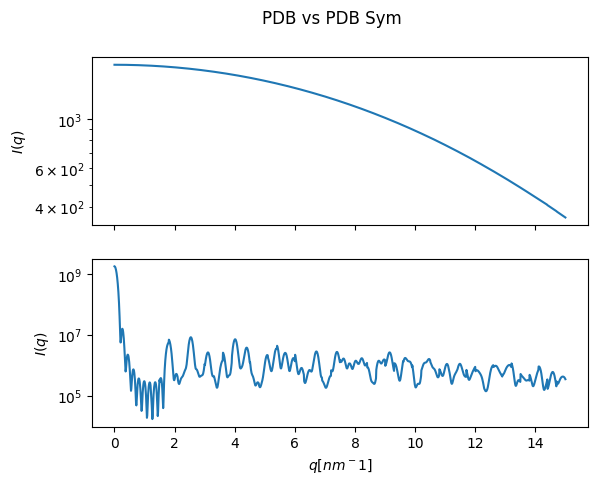

In [12]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('PDB vs PDB Sym')
ax1.semilogy(q_30, I_q_PDB)
ax1.set_ylabel('$I(q)$')
ax2.semilogy(q_15, I_q_PDB_sym)
ax2.set_xlabel('$q [nm^-1]$')
ax2.set_ylabel('$I(q)$')
plt.show()

We now calculate the sphere and UHC in a crystal for later use:

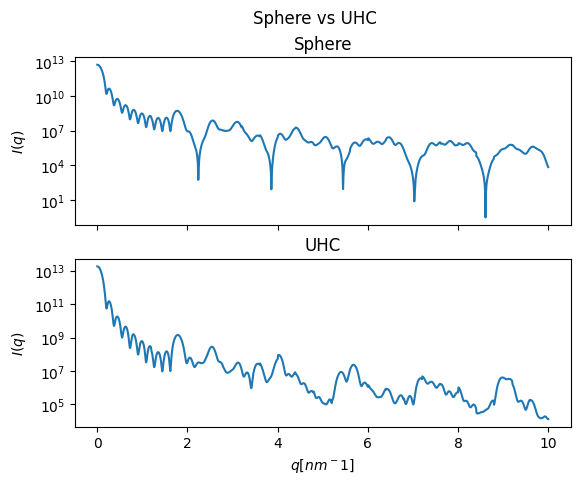

In [13]:
sphere_sym = ManualSymmetry()
sphere_sym.read_from_dol(filename_out)
sphere_sym.use_grid = False
sphere_sym.children.append(Test_sphere)

uhc_sym = ManualSymmetry()
uhc_sym.read_from_dol(filename_out)
uhc_sym.use_grid = False
uhc_sym.children.append(Test_uhc)

state_sphere_sym = CalculationInput()
state_sphere_sym.Domain.populations[0].add_model(sphere_sym)
state_sphere_sym.DomainPreferences.grid_size = grid_size
state_sphere_sym.DomainPreferences.q_max = q_max
state_sphere_sym.DomainPreferences.generated_points = 1000
state_sphere_sym.use_gpu = True

state_uhc_sym = CalculationInput()
state_uhc_sym.Domain.populations[0].add_model(uhc_sym)
state_uhc_sym.DomainPreferences.grid_size = grid_size
state_uhc_sym.DomainPreferences.q_max = q_max
state_uhc_sym.DomainPreferences.generated_points = 1000
state_uhc_sym.use_gpu = True

output_sphere_sym = runner.generate(state_sphere_sym)
output_uhc_sym = runner.generate(state_uhc_sym)

q_sphere_cryst = list(output_sphere_sym.graph.keys())
q_uhc_cryst = list(output_uhc_sym.graph.keys())
I_q_sphere_cryst = list(output_sphere_sym.graph.values())
I_q_uhc_cryst = list(output_uhc_sym.graph.values())

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('Sphere vs UHC')
ax1.semilogy(q_sphere_cryst, I_q_sphere_cryst)
ax1.set_title('Sphere')
ax1.set_ylabel('$I(q)$')
ax2.semilogy(q_uhc_cryst, I_q_uhc_cryst)
ax2.set_title('UHC')
ax2.set_xlabel('$q [nm^-1]$')
ax2.set_ylabel('$I(q)$')
plt.show()

## Amplitudes

We shall now show the functions we built for summing up and mulyiplying the amplitudes


In [14]:
## Create an amplitude filled with a structure factor
amp_out_file = r'./amp_out.ampj'
Amp_SF = g.Amp_of_SF(filename_out, grid_size, q_max)

Let's now multiply the just created structure factor amplitude once with the amplitude of a sphere and ones with a UHC (previously saved) and then sum them up. 

In [15]:
## Create a new amplitude with the sphere amplitude and the structure factor amplitude
Amp_sphere_SF = g.Amp_multi(Amp_SF, sphere_amp, N=1000)
Amp_uhc_SF = g.Amp_multi(Amp_SF, uhc_amp, N=1000)

## Sum both up
Amp_sphere_uhc_SF = g.Amp_sum(Amp_sphere_SF, Amp_uhc_SF)
Amp_sphere_uhc_SF.save(amp_out_file)

We can now input these into a state, calculate them and compare them with those previously calculated by D+

Set DomainPerefences grid_size to 50
Set DomainPreferences q_max to 10.0


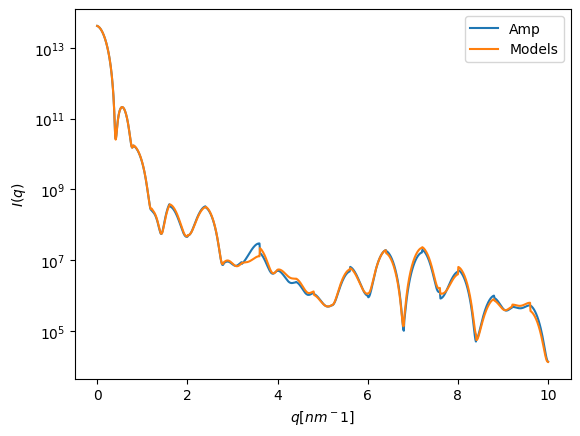

In [16]:
CI_of_amp = CalculationInput()
CI_of_amp.add_amplitude(Amp_sphere_uhc_SF)
CI_of_amp.DomainPreferences.calculated_points = 1000
CI_of_amp.use_gpu = True

output_amp = runner.generate(CI_of_amp)

q_amp = list(output_amp.graph.keys())   
I_q_amp = list(output_amp.graph.values())

man_sym_sphere = ManualSymmetry()
man_sym_sphere.read_from_dol(filename_out)
man_sym_sphere.use_grid = True
man_sym_sphere.children.append(Test_sphere)

man_sym_uhc = ManualSymmetry()
man_sym_uhc.read_from_dol(filename_out)
man_sym_uhc.use_grid = True
man_sym_uhc.children.append(Test_uhc)

CI_of_models = CalculationInput()
CI_of_models.Domain.populations[0].add_model(man_sym_sphere)
CI_of_models.Domain.populations[0].add_model(man_sym_uhc)
CI_of_models.DomainPreferences.grid_size = grid_size
CI_of_models.DomainPreferences.q_max = q_max
CI_of_models.DomainPreferences.generated_points = 1000
CI_of_models.use_gpu = True

output_models = runner.generate(CI_of_models)

q_models = list(output_models.graph.keys())
I_q_models = list(output_models.graph.values())

plt.figure()
plt.semilogy(q_amp, I_q_amp, label='Amp')
plt.semilogy(q_models, I_q_models, label='Models')
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.legend()
plt.show()

## g(r) module
Here we want to showcase the g_r module. First the helper functions:

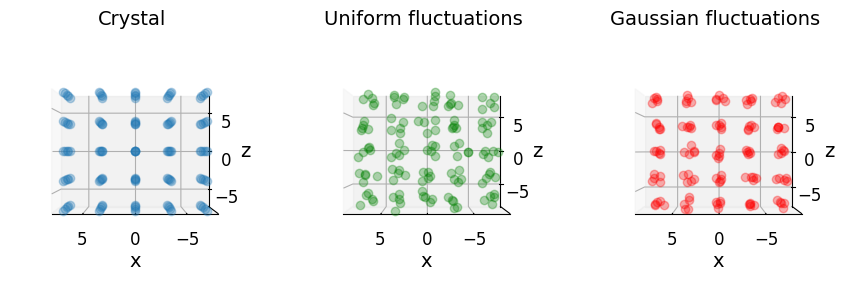

In [102]:
rand = 0.3

my_dol_name = r'../CF4_2.dol'
my_rand_dol_name = r'../CF4_rand.dol'
therm_dol_name = r'../CF4_therm.dol'

repx_2 = 5
repy_2 = 5
repz_2 = 5

a, alpha = 3.5, np.pi/2
cubic_lattice_2 = np.array([a, a, a, alpha, alpha, alpha])

my_cryst = g.build_crystal(cubic_lattice_2, repx_2, repy_2, repz_2, my_dol_name)
my_rand_cryst = g.build_crystal(cubic_lattice_2, repx_2, repy_2, repz_2, my_rand_dol_name, rand)
my_therm_cryst = g.thermalize(my_cryst, rand)
g.write_to_dol(therm_dol_name, my_therm_cryst)

xs, ys, zs = my_cryst[:, 0], my_cryst[:, 1], my_cryst[:, 2]
rand_xs, rand_ys, rand_zs = my_rand_cryst[:, 0], my_rand_cryst[:, 1], my_rand_cryst[:, 2]
therm_xs, therm_ys, therm_zs = my_therm_cryst[:, 0], my_therm_cryst[:, 1], my_therm_cryst[:, 2]

fig = plt.figure(figsize=plt.figaspect(0.45))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.view_init(0, 90, 0)
    ax.set_yticks([])
    if i == 0:
        ax.set_title('Crystal', size=14)
        ax.plot(xs, ys, zs, 'o', alpha=0.3)
    elif i == 1:
        ax.set_title('Uniform fluctuations', size=14)
        ax.plot(rand_xs, rand_ys, rand_zs, 'o', c='g', alpha=0.3)
    else:
        ax.set_title('Gaussian fluctuations', size=14)
        ax.plot(therm_xs, therm_ys, therm_zs, 'o', c='r', alpha=0.3)
    ax.tick_params(which='both', labelsize=12, color='k')
    ax.set_xlabel('x', size=14, labelpad=10)
    ax.set_zlabel('z', size=14)

Now we shall showcase the different ways g(r) and S(q) can be calculated.
Let's first start by calculating g(r) from a lattice with and without thermal fluctuations:

Calculating g(r) from model...
Calculating g(r) from model...


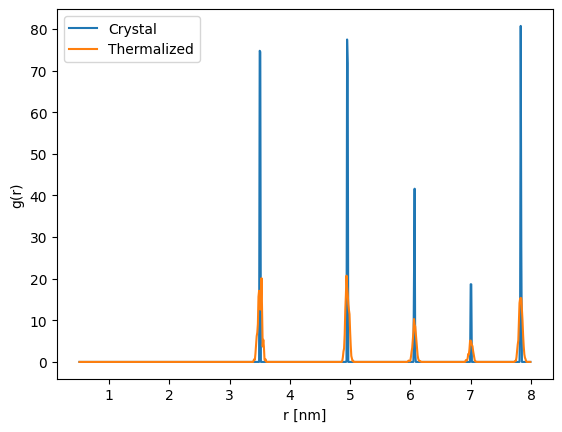

In [18]:
R = 0.01
rmax = 8
u_cryst=np.array([0.03, 0.03, 0.03])

r_model, g_r_model, rho, _ = g.g_r_from_model_slow(filename_out, [Lx, Ly, Lz], radius=R, r_min=.5, r_max=rmax)

r_model_therm, g_r_model_therm, rho_therm, _ = g.g_r_from_model_slow(filename_out, [Lx, Ly, Lz], radius=R, r_min=.5,
                                                                      r_max=rmax, Number_for_average_conf=5, Number_for_average_atoms=5, thermal=1, u=u_cryst)

plt.plot(r_model, g_r_model, label='Crystal')
plt.plot(r_model_therm, g_r_model_therm, label='Thermalized')
plt.xlabel('r [nm]')
plt.ylabel('g(r)')
plt.legend()
plt.show()

Now, we can do the same but this time calculate S(q);

In [19]:
# dol_mat = g.build_crystal(cubic_lattice, repx, repy, repz, filename_out)
q, S_q_model, rho = g.S_Q_from_model(filename_out, q_max=8)
q_therm, S_q_model_therm, _ = g.S_Q_from_model(filename_out, q_max=8, thermal=True, u=u_cryst, Number_for_average_conf=5)

Finished iteration 1 of 5 iterations.
Finished iteration 2 of 5 iterations.
Finished iteration 3 of 5 iterations.
Finished iteration 4 of 5 iterations.
Finished iteration 5 of 5 iterations.


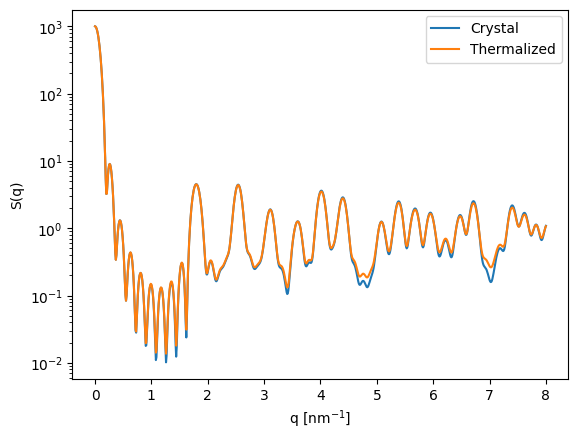

In [20]:
plt.semilogy(q, S_q_model, label='Crystal')
plt.semilogy(q_therm, S_q_model_therm, label='Thermalized')
plt.xlabel('q [nm$^{-1}$]')
plt.ylabel('S(q)')
plt.legend()
plt.show()

We can, from the g(r), calculate the S(q) by either using Simpson integration or the DST algorithm:

In [21]:
q_max = 8
rmaxtemp = 32.5

r_model_temp, g_r_model_temp, _, _ = g.g_r_from_model_slow(filename_out, [Lx, Ly, Lz], radius=0.3, r_min=.5, r_max=rmaxtemp)

q_simps, s_q_simps = g.s_q_from_g_r(r_model_temp, g_r_model_temp, rho, type='Simpson', q_max=q_max)
#q_dst, s_q_dst = g.s_q_from_g_r(r_model, g_r_model, rho, type='DST', q_max=q_max, factor=2)

r_simps_temp, g_r_simps_temp = g.g_r_from_s_q(q, S_q_model, rho, r_min=.5, r_max=rmaxtemp, type='Simpson')

q_g, s_q_g = g.s_q_from_g_r(r_simps_temp, g_r_simps_temp, rho, q_max=q_max, type='Simpson')

Calculating g(r) from model...


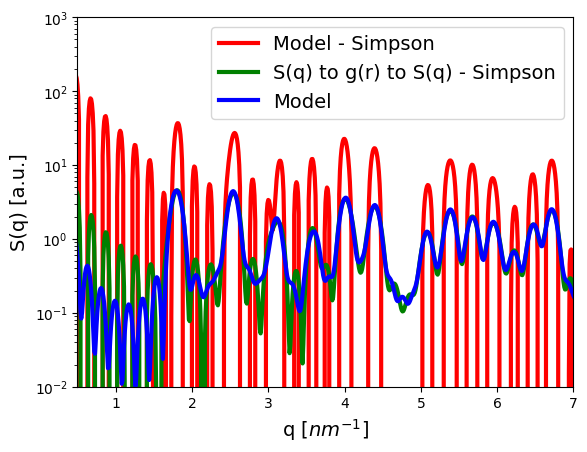

In [22]:
plt.figure()
plt.semilogy(q_simps, s_q_simps, 'r', label='Model - Simpson', lw=3)
plt.semilogy(q_g, s_q_g, 'g', label='S(q) to g(r) to S(q) - Simpson', lw=3)
plt.semilogy(q, S_q_model, 'b', label='Model', lw=3)
plt.xlabel('q $[nm^{-1}]$', size=14)
plt.ylabel('S(q) [a.u.]', size=14)
plt.xlim(0.5, 7)
plt.ylim(1e-2, 1e3)
plt.legend(fontsize=14, loc='center right')

And now we can also calculate this from the intensity (those previously calculated):

In [23]:
q_max = 10
N = repx * repy * repz
S_q_I_sp = g.S_Q_from_I(I_q_sphere_cryst, I_q, N)
S_q_I_uhc = g.S_Q_from_I(I_q_uhc_cryst, I_q_uhc, N)

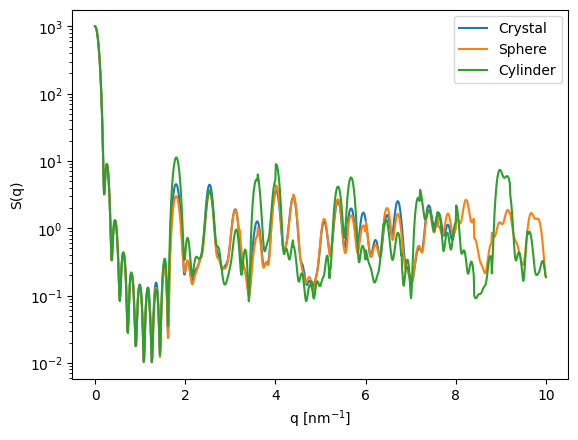

In [24]:
plt.semilogy(q, S_q_model, label='Crystal')
plt.semilogy(q_sphere_cryst, S_q_I_sp, label='Sphere')
plt.semilogy(q_uhc_cryst, S_q_I_uhc, label='Cylinder')
plt.xlabel('q [nm$^{-1}$]')
plt.ylabel('S(q)')
plt.legend()
plt.show()

Now we shall use the structure factors we previously calculated and calculate g(r) from them. We shall also return one to S(q):

In [25]:
from scipy.integrate import simpson

q, S_q_model, rho = g.S_Q_from_model_slow(filename_out, q_max=100)

r_simps, g_r_simps = g.g_r_from_s_q(q, S_q_model, rho, r_min=.5, r_max=rmax, type='Simpson')
r_dst, g_r_dst = g.g_r_from_s_q(q, S_q_model, rho, r_min=.5, r_max=rmax, type='DST')

#q_g, s_q_g = g.s_q_from_g_r(r_simps, g_r_simps, rho, q_max=q_max, type='Simpson')

In [26]:
Rad = 0.1

u_cryst=np.array([0.1, 0.1, 0.1])
r_model_rad, g_r_model_rad, rho_rad, _ = g.g_r_from_model_slow(filename_out, [Lx, Ly, Lz], radius=Rad, r_min=.5, r_max=rmax)
r_model_therm_rad, g_r_model_therm_rad, rho_therm_rad, _ = g.g_r_from_model_slow(filename_out, [Lx, Ly, Lz], radius=Rad, r_min=.5, r_max=rmax, Number_for_average_conf=5, Number_for_average_atoms=5, thermal=1, u=u_cryst)

Calculating g(r) from model...
Calculating g(r) from model...
5.900684493205458 5.713977501565294 5.299970835306495


In [87]:
model_int = (3.4 < r_model_rad) & (r_model_rad < 3.6)
simps_int = (3.4 < r_simps) & (r_simps < 3.6)
dst_int = (3.5 < r_dst) & (r_dst < 3.7)

N_mod = simpson(rho_rad * g_r_model_rad[model_int] * 4 * np.pi * r_model_rad[model_int]**2, r_model_rad[model_int])
N_simps = simpson(rho * g_r_simps[simps_int] * 4 * np.pi * r_simps[simps_int]**2, r_simps[simps_int])
N_dst = simpson(rho * g_r_dst[dst_int] * 4 * np.pi * r_dst[dst_int]**2, r_dst[dst_int])
print(N_mod, N_simps, N_dst)

5.900684493205458 5.713977501565294 5.299970835306495


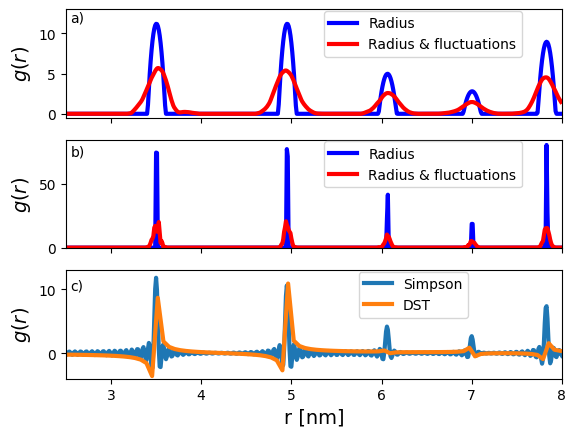

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

ax1.plot(r_model_rad, g_r_model_rad, 'b', label='Radius', lw=3)
ax1.plot(r_model_therm_rad, g_r_model_therm_rad, 'r', label='Radius & fluctuations', lw=3)
ax1.set_ylabel('$g(r)$', size=14)
ax1.set_xlim(2.5, 8)
ax1.set_ylim(-0.5, 13)
ax1.legend(fontsize=10, loc=(.52, .56))

ax2.plot(r_model, g_r_model, 'b', label='Radius', lw=3)
ax2.plot(r_model_therm, g_r_model_therm, 'r', label='Radius & fluctuations', lw=3)
ax2.set_ylabel('$g(r)$', size=14)
ax2.set_xlim(2.5, 8)
ax2.set_ylim(-0.5,85)
ax2.legend(fontsize=10, loc=(.52, .56))

ax3.plot(r_simps, g_r_simps, label='Simpson', lw=3)
ax3.plot(r_dst, g_r_dst, label='DST', lw=3)
ax3.set_ylabel('$g(r)$', size=14)
ax3.set_xlabel('r [nm]', size=14)
ax3.set_xlim(2.5, 8)
ax3.set_ylim(-4, 13)
ax3.legend(fontsize=10, loc=(.59, .56))

ax1.annotate('a)', xy=(2.55, 11.5))
ax2.annotate('b)', xy=(2.55, 72))
ax3.annotate('c)', xy=(2.55, 10))

plt.savefig(r'D:\Eytan\G_R_and_2D\Pics\RDF_Model_VS_DST_fluct_3p5_lattice.png')



## 2D Intensities
First we shall showcase the scattering from a single orientation. For this we shall start by building a graphene lattice:

In [28]:
graphene_dol = r'./graphene_25x25_xz.dol'
a = 0.246
graphene_lattice = a / 2 * np.array([[1, 0, np.sqrt(3)], [0, 1, 0], [1, 0, -np.sqrt(3)]])
reps = [25, 1, 25]
graphene_mat = g.build_crystal(graphene_lattice, *reps, graphene_dol)

qp = np.linspace(-70, 70, 3500)

In [40]:
C_PDB = PDB(r'..\Carbon.pdb')
C_PDB.centered = True
C_PDB.extra_params.solvent_method.value = 0

graphene_unit = ManualSymmetry()
graphene_unit.read_from_dol(graphene_dol)
graphene_unit.children.append(C_PDB)

graphene_tot = ManualSymmetry()
graphene_tot.add_layer()
graphene_tot.add_layer()
graphene_tot.layer_params[1].z.value = a/3**.5
graphene_tot.children.append(graphene_unit)

Graphene = CalculationInput()
Graphene.Domain.populations[0].add_model(graphene_tot)
Graphene.DomainPreferences.q_max = 70
Graphene.DomainPreferences.grid_size = 550
Graphene.DomainPreferences.orientation_method = 'Monte Carlo (Mersenne Twister)'
Graphene.DomainPreferences.use_grid = True
Graphene.DomainPreferences.generated_points = int(70 * 100)
Graphene.DomainPreferences.convergence = 1e-3
Graphene.DomainPreferences.orientation_iterations = 1e6
Graphene.DomainPreferences.apply_resolution = False
Graphene.export_all_parameters(graphene_dol[:-3] + 'state')

graphene_out = runner.generate(Graphene)
graphene_amp = runner.get_amp(graphene_tot.model_ptr)

I_graph = graphene_amp.get_crystal_intensity(q_min=1, q_max=69.99, calculated_points=3500)


Text(0, 0.5, '$q_z[nm^{-1}]$')

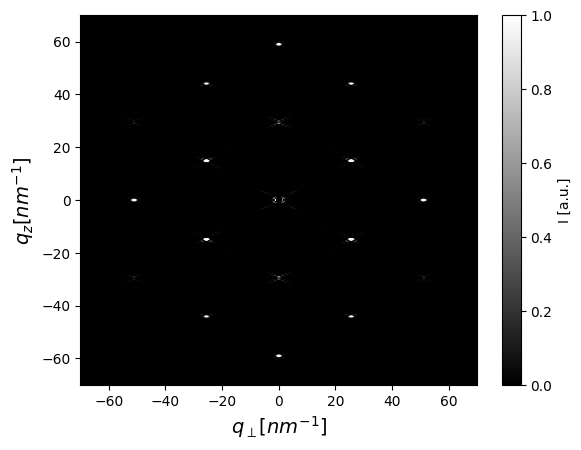

In [41]:
from skimage import exposure

p2_graph, p98_graph = np.percentile(I_graph, (2, 99.95))
I_graph_rescale = exposure.rescale_intensity(I_graph, in_range=(p2_graph, p98_graph))

plt.figure()
plt.pcolormesh(qp, qp, I_graph_rescale, cmap='gray', zorder=1)
plt.colorbar(label='I [a.u.]')
plt.xlabel('$q_\perp[nm^{-1}]$', size=14)
plt.ylabel('$q_z[nm^{-1}]$', size=14)
# plt.savefig(graphene_dol[1:-4] + '_w_beamstop.png')